## TP2: Bag-of-Words Classification with Histograms of Oriented Gradients

**DU Jack - LAROYE--LANGOUËT Ambroise | SIA**

In this exercise, you will build an image classifier based on the bag-of-words (BoW) approach and the nearest neighbors algorithm.

### 1.1 Dataset

We will use the STL-10 dataset for training and testing our model. STL-10 contains 96 × 96 color images that belong to one of the following ten semantic classes : airplane, bird, car, cat, deer, dog, horse, monkey, ship, and truck. It contains a training set with 500 images from each class (5000 images in total) and a test set with 800 images from each class (8000 images in
total). The training set is used to optimize the model parameters, whereas the test set is used to evaluate the model performance.

### 1.2 Bag-of-Words Classification Pipeline Overview

The BoW pipeline is illustrated in Figure 1. At training time, HOG features are extracted densely from each image. K-means clustering is applied to the set of extracted features from the entire training set, resulting in K centroids which serve as the visual words. Each training image is finally represented as a bag of such words in the form of a BoW histogram vector, based on the proximity of its HOG feature vectors with the K visual words. At testing time, the aforementioned steps for computing a BoW histogram are applied to each test image. The final classifier is nonparametric and it is based on the nearest neighbor principle : the label of the
nearest neighbor of the test image in the training set (based on BoW histogram representation
of images) is predicted to be the label of the test image.

More formally, denote the training set as a set of pairs of BoW histograms and class labels

T = {(hi, ci) : i = 1, . . . , T, ci ∈ {1, . . . , C}},

where C is the total number of semantic classes we consider. For a test image that is represented
as a BoW histogram g, the nearest neighbor classifier predicts the label



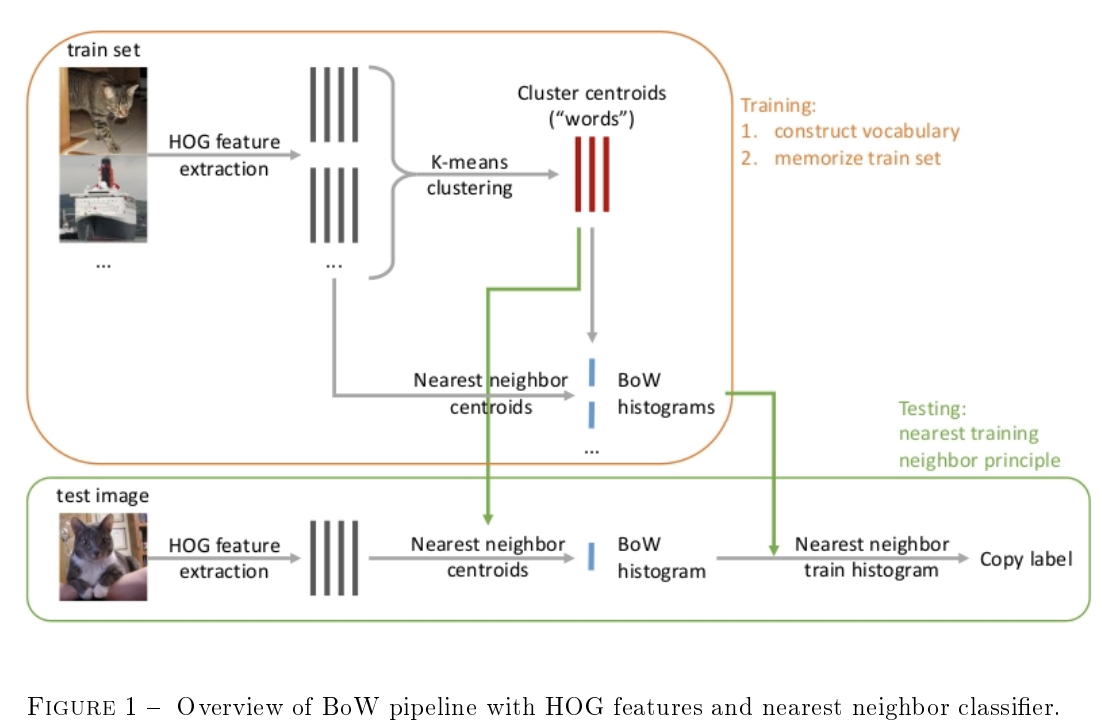

cˆ = ckˆ, (2)
where ˆk = arg mink∈{1,...,T}{d(g, hk)}, d(., .) denotes some distance metric between two BoW histograms.

**Question :** <br>
Suppose that we do not use any approximation technique (e.g. K-D tree) to determine the nearest neighbor in the training set, but compute all required distances exactly. What is the space and time complexity of predicting the label of a single test image with respect to the size of the training set ?

#### **Space complexity**:

We consider that:
  - **T**, the total number of training images.
  - **K**, the number of visual words (BoW vocabulary size).
  - Each BoW histogram has **K** bins (each representing a visual word).

For nearest neighbor prediction, we need to store:
  - The BoW histograms for all training images.
  - The class labels for the training images.


- **Storage of histograms**:

For each image, the histogram is represented as a vector of length K. It requires **T x K space** for storing the histograms.
- **Storage of labels**:

Each training image has a corresponding label c i ∈ { 1 , … , C } (where C is the number of classes). It requires **T space** for storing the labels.

To conclude, the overall space complexity is: **O ( T x K )**.<br>
(The space for labels is O(T), which is relatively negligible compared to storing the histograms.)

<br>

#### **Time complexity**:

To predict the label of a test image, we have to:
- Compute the BoW histogram for the test image
- Compute the distance between the test images BoW histogram g and the BoW histogram of each training image. <br> This requires computing the distance (e.g., Euclidean distance) between two vectors of length K. It takes **O(K)**.
- Compute the distance for all T training histograms, which takes: **O(TxK)**

- Find the training image with the smallest distance. It requires **O(T)**.

<br>

To conclude, the overall time complexity for predicting the label of a single test image is: **O(TxK)**.

In [1]:
# import data and unzip to colab tmp folder
from google.colab import drive
drive.mount('/content/drive')

!unzip -q '/content/drive/MyDrive/3A/Image & Video processing/TP2/STL10.zip' -d "/content/Data"

Mounted at /content/drive


### 1.3 Feature Description with Histograms of Oriented Gradients (HOG)
The first step in the BoW pipeline is feature extraction for a given image. Details of this
step are given below :

- **Step 1 :** Define a dense regular grid of n_points_x × n_points_y points on the image.
Write a function that outputs the column (x) indices and the corresponding row (y) indices of the grid points as two separate 1D NumPy arrays of length n_points_x ×
n_points_y. <br>
(**Hint :** You might use the functions numpy.linspace and numpy.meshgrid).


In [2]:
import numpy as np

img_repo = '/content/Data/stl10_raw/test/airplane/airplane_test_000.png'

def generate_grid_points(n_points_x, n_points_y, image_width, image_height):
    # Generate evenly spaced points along x and y axes
    x_points = np.linspace(0, image_width - 1, n_points_x)
    y_points = np.linspace(0, image_height - 1, n_points_y)

    # Create a grid of coordinates from the x and y points
    x_grid, y_grid = np.meshgrid(x_points, y_points)

    # Flatten the grid to get two 1D arrays for x and y coordinates
    x_indices = x_grid.flatten().astype(int)
    y_indices = y_grid.flatten().astype(int)

    return x_indices, y_indices

# Example usage
n_points_x = 5
n_points_y = 4
image_width = 640
image_height = 480

x_indices, y_indices = generate_grid_points(n_points_x, n_points_y, image_width, image_height)

print("X indices:", x_indices)
print("Y indices:", y_indices)

X indices: [  0 159 319 479 639   0 159 319 479 639   0 159 319 479 639   0 159 319
 479 639]
Y indices: [  0   0   0   0   0 159 159 159 159 159 319 319 319 319 319 479 479 479
 479 479]


- **Step 2 :** Compute HOG feature descriptors for all grid points from the previous step. <br>
For each point, the HOG feature description operates on a square image patch centered at the point and partitioned into a 4 × 4 set of cells. Each cell has a size of cell_height× cell_width pixels. In our case, cell_height = cell_width = 4, so the entire square patch has a size of 16 × 16 pixels. Compute the approximate image gradient using the Sobel operator and get the direction of the gradient as an angle in the interval [−π, π]. For each grid point, compute the 8-bin histogram of gradient directions at pixels that belong to each separate cell of the corresponding patch and concatenate the histograms from all the cells into the final 128-D HOG descriptor for the point. Write a function that outputs a 2D NumPy array of size n_points × 128, where n_points is the total number of grid points defined on the image. <br>
(**Hint :** You might use the functions scipy.ndimage.sobel and
numpy.histogram).

In [3]:
import numpy as np

def HOG(image, grid_points):
    # Calculating gradients
    gradient_x = np.gradient(image, axis=1)
    gradient_y = np.gradient(image, axis=0)
    magnitude = np.sqrt(gradient_x ** 2 + gradient_y ** 2)
    direction = np.arctan2(gradient_y, gradient_x) * 180 / np.pi

    # Direction normalization
    direction[direction < 0] += 360

    # Define cells' size
    cell_size = (4, 4)
    n_cells_x = image.shape[1] // cell_size[1]
    n_cells_y = image.shape[0] // cell_size[0]

    hog_features = []

    for cell_y in range(n_cells_y):
        for cell_x in range(n_cells_x):
            # Define the cutting indexes
            cell_start_x = cell_x * cell_size[1]
            cell_end_x = (cell_x + 1) * cell_size[1]
            cell_start_y = cell_y * cell_size[0]
            cell_end_y = (cell_y + 1) * cell_size[0]

            # Make sure that indexes are integers
            cell_start_x = int(cell_start_x)
            cell_end_x = int(cell_end_x)
            cell_start_y = int(cell_start_y)
            cell_end_y = int(cell_end_y)

            # Extract gradiens and angles for the pixels of the cell
            cell_magnitudes = magnitude[cell_start_y:cell_end_y, cell_start_x:cell_end_x]
            cell_directions = direction[cell_start_y:cell_end_y, cell_start_x:cell_end_x]

            # Histogramm of direction
            hist, _ = np.histogram(cell_directions, bins=9, range=(0, 180), weights=cell_magnitudes)

            hog_features.append(hist)

    return np.array(hog_features)


### 1.4 Visual Vocabulary Construction with K-means Clustering

The second step in the BoW pipeline is to construct a vocabulary (or codebook) of K visual
words by applying K-means clustering to the complete set of HOG descriptors from all images in
the training set. The centroids which are computed with K-means serve as the visual codebook
words. The K-means algorithm follows the steps below :
- **Step 1 :** Initialize random cluster centroids.
- **Step 2 :** Assign each data point to the cluster whose centroid is nearest to the point
with respect to the Euclidean distance.
- **Step 3 :** Update each cluster centroid to the mean of all data points that are currently assigned to the cluster. <br>
Steps 2 and 3 are repeated until convergence. Write a function for the K-means algorithm that outputs a 2D NumPy array of size K x 128, containing the final cluster centroids as its rows <br>
(**Hint :** You might use the functions numpy.random.permutation and scipy.spatial.distance.cdist).


In [4]:
# STEP1: Initialize random cluster centroids.
import numpy as np

'''
Input:
HOG_descriptors (ndarray): Array of all HOG descriptors from the training set. Shape: (n_descriptors, 128)
K (int): Number of clusters (visual words)

Output:
centroids (ndarray): Array of K randomly initialized centroids. Shape: (K, 128)
'''

def initialize_random_centroids(HOG_descriptors, K):
    # Shuffle the indices of HOG descriptors
    shuffled_indices = np.random.permutation(HOG_descriptors.shape[0])

    # Select the first K descriptors as initial centroids
    centroids = HOG_descriptors[shuffled_indices[:K]]

    return centroids


# Example
n_descriptors = 10000  # Example total number of HOG descriptors
HOG_descriptors = np.random.rand(n_descriptors, 128) #Example of HOG_descriptor

K = 100  # Number of visual words (clusters)
centroids = initialize_random_centroids(HOG_descriptors, K)
print("Randomly initialized centroids:", centroids)


Randomly initialized centroids: [[0.81177642 0.57393809 0.81622994 ... 0.79127753 0.31142695 0.28467759]
 [0.236844   0.95126515 0.19150576 ... 0.33612876 0.96209806 0.43621057]
 [0.82602039 0.09953574 0.8530196  ... 0.89070246 0.8311562  0.55575899]
 ...
 [0.38397268 0.75651073 0.28162371 ... 0.97393844 0.22540206 0.45232314]
 [0.91910332 0.98124599 0.11262103 ... 0.92365373 0.85711685 0.66065777]
 [0.46752185 0.69883647 0.83585606 ... 0.42530167 0.05414085 0.15609742]]


In [5]:
# STEP2: Assign each data point to the cluster whose centroid is nearest to the point with respect to the Euclidean distance.
from scipy.spatial.distance import cdist

"""
Input:
HOG_descriptors (ndarray): Array of HOG descriptors. Shape: (n_descriptors, 128)
centroids (ndarray): Array of K centroids. Shape: (K, 128)

Output:
labels (ndarray): Array of cluster labels for each descriptor. Shape: (n_descriptors,)
"""

def assign_clusters(HOG_descriptors, centroids):
    # Compute the distance from each descriptor to each centroid
    distances = cdist(HOG_descriptors, centroids, metric='euclidean')

    # Assign each descriptor to the nearest centroid (minimum distance)
    labels = np.argmin(distances, axis=1)

    return labels

In [6]:
# STEP3: Update each cluster centroid to the mean of all data points that are currently assigned to the cluster

"""
Input:
HOG_descriptors (ndarray): Array of HOG descriptors. Shape: (n_descriptors, 128)
labels (ndarray): Array of cluster labels for each descriptor. Shape: (n_descriptors,)
K (int): Number of clusters (visual words)

Output:
centroids (ndarray): Updated centroids. Shape: (K, 128)
"""

def update_centroids(HOG_descriptors, labels, K):
    # Initialize an array to store the new centroids
    centroids = np.zeros((K, HOG_descriptors.shape[1]))

    for k in range(K):
        # Select all descriptors assigned to cluster k
        cluster_points = HOG_descriptors[labels == k]

        # Compute the mean of the points in the cluster to update the centroid
        if len(cluster_points) > 0:
            centroids[k] = np.mean(cluster_points, axis=0)

    return centroids

In [7]:
# K-means algorithm that outputs a 2D NumPy array of size K x 128, containing the final cluster centroids as its rows

"""
Input:
HOG_descriptors (ndarray): Array of HOG descriptors from the training set. Shape: (n_descriptors, 128)
K (int): Number of clusters (visual words)
max_iters (int): Maximum number of iterations
tol (float): Tolerance for convergence (change in centroids)

Output:
centroids (ndarray): Final centroids (visual vocabulary). Shape: (K, 128)
"""

def kmeans_clustering(HOG_descriptors, K, max_iters=100, tol=1e-4):
    # Step 1: Initialize centroids
    centroids = initialize_random_centroids(HOG_descriptors, K)

    for i in range(max_iters):
        # Step 2: Assign each descriptor to the nearest centroid
        labels = assign_clusters(HOG_descriptors, centroids)

        # Step 3: Update centroids
        new_centroids = update_centroids(HOG_descriptors, labels, K)

        # Check for convergence (if the centroids do not change significantly)
        if np.linalg.norm(new_centroids - centroids) < tol:
            print(f"Converged after {i+1} iterations.")
            break

        # Update centroids for the next iteration
        centroids = new_centroids

    return centroids

In [8]:
## TEST
# Number of visual words (clusters)
K = 10

# Example HOG descriptors, replace with real data
HOG_descriptors = np.random.rand(10000, 128)  # 10,000 HOG descriptors

# Perform K-means clustering to get the visual vocabulary (centroids)
final_centroids = kmeans_clustering(HOG_descriptors, K)

print("Final cluster centroids (visual vocabulary):", final_centroids)


Converged after 95 iterations.
Final cluster centroids (visual vocabulary): [[0.45340229 0.44891558 0.46130687 ... 0.4723565  0.50962755 0.51245316]
 [0.42643216 0.55887329 0.48380637 ... 0.48997262 0.44214731 0.46131457]
 [0.55134758 0.46491002 0.57824155 ... 0.50183886 0.41959217 0.48728609]
 ...
 [0.48422488 0.49635546 0.41424952 ... 0.48412872 0.4754936  0.54602401]
 [0.52798728 0.48927763 0.47161226 ... 0.5712785  0.55323958 0.45891643]
 [0.50195442 0.52680933 0.49661424 ... 0.4550844  0.53648847 0.51574219]]


### 1.5 BoW Histogram Representation

The third step in the BoW pipeline is to compute the BoW histogram for each image, which serves as a high-level representation of the image. The BoW histogram is a K-bin histogram, where the k-th bin counts how many HOG descriptors of the input image are closest to the k-th
codebook word (centroid). Write a function that computes the BoW histograms for all images belonging to a set (train or test), along with creation of an array containing the ground truth labels of these images <br>
(**Hint :** You might reuse the function implemented for the previous task and the function numpy.bincount).

In [9]:
# Computes the BoW histograms for all images in the dataset

from scipy.spatial.distance import cdist

"""
args:
- HOG_descriptors_per_image (list of ndarray): List of HOG descriptor arrays for each image. Each array has shape (n_descriptors, 128) for each image.
- centroids (ndarray): Array of K centroids (visual words) from K-means clustering. Shape: (K, 128)
- labels (list of int): Ground truth labels for each image.

return:
- bow_histograms (ndarray): Array of BoW histograms for all images. Shape: (n_images, K)
- ground_truth_labels (ndarray): Array of ground truth labels for all images. Shape: (n_images,)
"""

def compute_bow_histograms(HOG_descriptors_per_image, centroids, labels):
    K = centroids.shape[0]  # Number of visual words
    n_images = len(HOG_descriptors_per_image)

    # Initialize an array to store the BoW histograms for each image
    bow_histograms = np.zeros((n_images, K), dtype=np.float32)

    # Ground truth labels array (already given as input)
    ground_truth_labels = np.array(labels)

    for i, HOG_descriptors in enumerate(HOG_descriptors_per_image):
        # Reshape HOG_descriptors to ensure it's 2D
        HOG_descriptors = np.reshape(HOG_descriptors, (-1, HOG_descriptors.shape[-1]))

        # Check if centroids and descriptors are 2D
        assert centroids.ndim == 2, "Centroids should be a 2D array."
        assert HOG_descriptors.ndim == 2, "HOG descriptors should be a 2D array."

        # Assign each HOG descriptor to the nearest visual word (centroid)
        assigned_clusters = assign_clusters(HOG_descriptors, centroids)

        # Build the histogram by counting the number of descriptors assigned to each cluster
        bow_histogram = np.bincount(assigned_clusters, minlength=K)

        # Store the normalized histogram in the array
        bow_histograms[i, :] = bow_histogram / np.sum(bow_histogram)  # Normalize the histogram to sum to 1

    return bow_histograms, ground_truth_labels


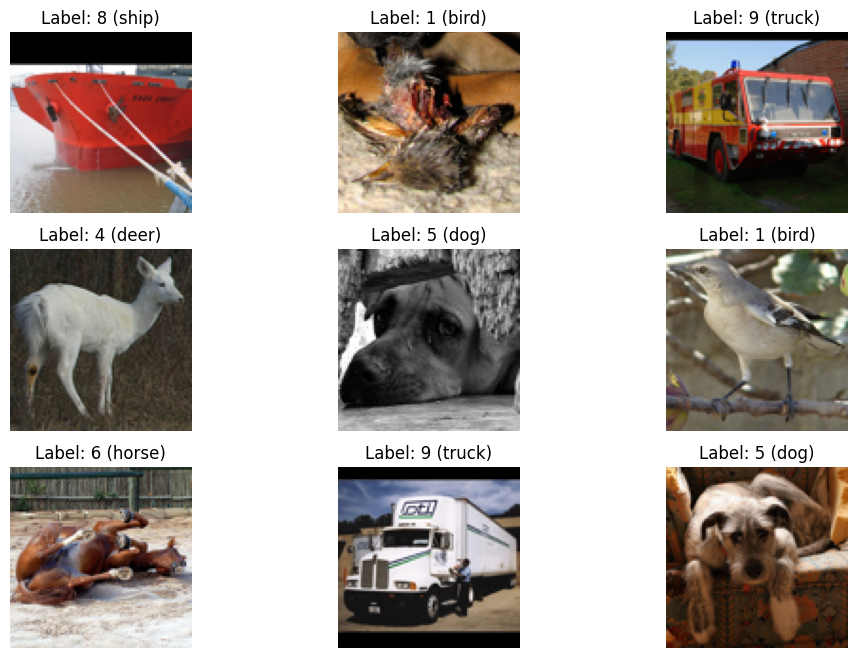

In [10]:
# SIDE WORK: Match class folder with labels

import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import LabelEncoder
import random

dataset_path = "/content/Data/stl10_raw/test/"

classes = [folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))]

label_encoder = LabelEncoder()
label_encoder.fit(classes)
encoded_labels = label_encoder.transform(classes)

# Create a dictionary to match class folders and labels
class_to_label = dict(zip(classes, encoded_labels))

images = []
labels = []

for class_name in classes:
    class_folder = os.path.join(dataset_path, class_name)
    for image_name in os.listdir(class_folder):
          image_path = os.path.join(class_folder, image_name)
          images.append(image_path)
          labels.append(class_to_label[class_name])


### EVERYTHING IS HERE
images = np.array(images)
labels = np.array(labels)
###

num_images_to_show = min(9, len(images))  # Display in max 9 images
random_indices = random.sample(range(len(images)), num_images_to_show)

# Display some random pictures to check if everything works well.
plt.figure(figsize=(12, 8))
for i, index in enumerate(random_indices):
    plt.subplot(3, 3, i + 1)
    img = mpimg.imread(images[index])
    plt.imshow(img)
    label = labels[index]
    plt.title(f"Label: {label} ({label_encoder.inverse_transform([label])[0]})")
    plt.axis('off')
!

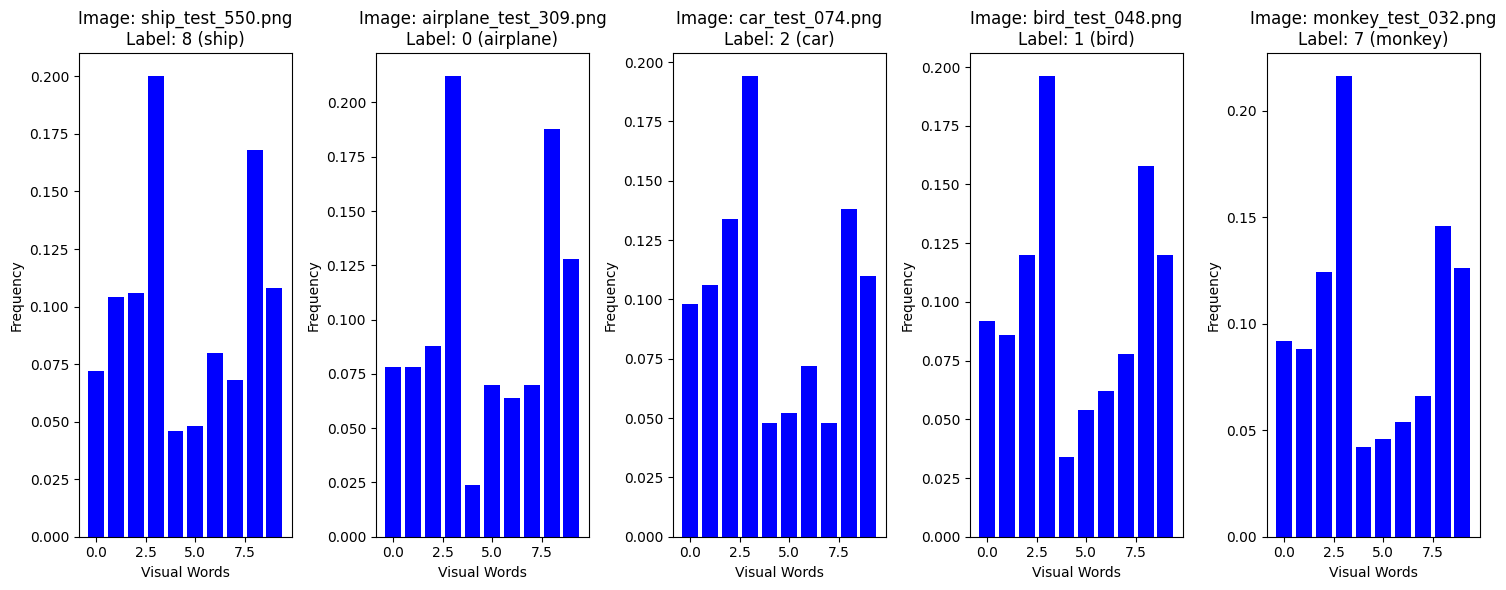

In [11]:
K = 10  # number of visual words
centroids = np.random.rand(K, 128)

"""
Visualizes BoW histograms for a subset of images.

args:
- images (array-like): Array of image paths.
- labels (array-like): Array of image labels.
- centroids (ndarray): Array of centroids (visual words) from K-means clustering.
- hog_descriptors_per_image (list of ndarray): List of HOG descriptors for each image.
- label_encoder (LabelEncoder): Encoder to convert between labels and class names.
- num_images_to_show (int): Number of random images to show BoW histograms for.
"""

# Function to visualize the BoW histograms
def show_bow_histograms(images, labels, centroids, hog_descriptors_per_image, label_encoder, num_images_to_show=5):
    # Get the BoW histograms for the given images and their labels
    bow_histograms, _ = compute_bow_histograms(hog_descriptors_per_image, centroids, labels)

    # Randomly select images to show their BoW histograms
    random_indices = random.sample(range(len(images)), min(num_images_to_show, len(images)))

    plt.figure(figsize=(15, 6))  # Set the size of the overall plot
    for i, index in enumerate(random_indices):
        # Display BoW histogram for each selected image
        plt.subplot(1, num_images_to_show, i + 1)  # Create a subplot
        plt.bar(range(K), bow_histograms[index], color='blue')  # Show the histogram as a bar chart

        # Get the encoded label and class name
        label = labels[index]
        class_name = label_encoder.inverse_transform([label])[0]  # Get original class name

        plt.title(f"Image: {os.path.basename(images[index])}\nLabel: {label} ({class_name})")
        plt.xlabel('Visual Words')
        plt.ylabel('Frequency')
        plt.tight_layout()

    plt.show()

# Example usage
hog_descriptors_per_image = [np.random.rand(500, 128) for _ in range(len(images))]
show_bow_histograms(images, labels, centroids, hog_descriptors_per_image, label_encoder, num_images_to_show=5)


### 1.6 Nearest Neighbor Classifier

The fourth step in the BoW pipeline is to build a nearest neighbor classifier. Write a function that outputs a 1D NumPy array containing the predicted labels for the corresponding test BoW histograms.
We'll use the Euclidean (L2) norm to measure distances between BoW histograms <br>
(**Hint :** You might reuse the function implemented for the previous task).

In [12]:
"""
Predict labels for test BoW histograms based on the nearest train BoW histograms using Euclidean distance.

args:
- test_bow_histograms: 2D NumPy array of shape (n_test_samples, n_visual_words)
- train_bow_histograms: 2D NumPy array of shape (n_train_samples, n_visual_words)
- train_labels: 1D NumPy array containing the labels for the training set

Returns:
- predicted_labels: 1D NumPy array of predicted labels for the test set
"""

def predict_labels(test_bow_histograms, train_bow_histograms, train_labels):
    predicted_labels = np.zeros(test_bow_histograms.shape[0], dtype=int)

    # Iterate over each test BoW histogram
    for i, test_hist in enumerate(test_bow_histograms):
        # Compute Euclidean distances to all train BoW histograms
        distances = np.linalg.norm(train_bow_histograms - test_hist, axis=1)

        # Find the index of the nearest train BoW histogram
        nearest_idx = np.argmin(distances)

        # The predicted label is the label of the nearest train histogram
        predicted_labels[i] = train_labels[nearest_idx]

    return predicted_labels

Selected Test Image: /content/Data/stl10_raw/test/bird/bird_test_740.png
True Label: 1
Predicted Label: 1 (bird)


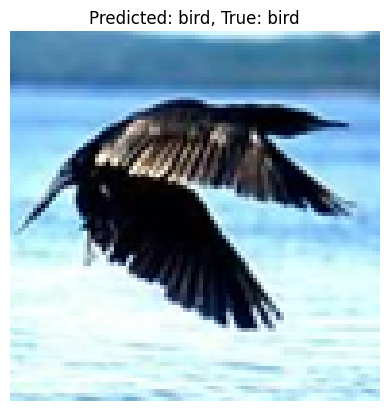

In [13]:
## TEST PREDICTION FOR 1 RANDOM PICTURE

import numpy as np
import random
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Step 1: Load the training and test images and compute their BoW histograms
# Assuming you have preprocessed your dataset and obtained BoW histograms and labels.

train_images = images[:100]  # Assuming first 100 images are training images
test_images = images[100:110]  # Next 10 images are test images

# Sample HOG descriptors (you should replace these with your actual HOG descriptors)
hog_descriptors_per_image_train = [np.random.rand(500, 128) for _ in range(len(train_images))]
hog_descriptors_per_image_test = [np.random.rand(500, 128) for _ in range(len(test_images))]

# Sample BoW Histograms (replace with actual computed BoW histograms)
centroids = np.random.rand(8, 128)  # Example centroids
train_bow_histograms, _ = compute_bow_histograms(hog_descriptors_per_image_train, centroids, labels[:100])
test_bow_histograms, _ = compute_bow_histograms(hog_descriptors_per_image_test, centroids, labels[100:110])

# Step 2: Select a test image
test_index = 0  # Change this index to test different images
selected_test_hist = test_bow_histograms[test_index:test_index + 1]  # Get the corresponding BoW histogram
selected_test_image = test_images[test_index]  # Get the image path
selected_test_label = labels[100 + test_index]  # Get the true label for this test image

# Step 3: Use the predict_labels function to predict the label
predicted_labels = predict_labels(selected_test_hist, train_bow_histograms, labels[:100])

# Display the results
print(f"Selected Test Image: {selected_test_image}")
print(f"True Label: {selected_test_label}")
print(f"Predicted Label: {predicted_labels[0]} ({label_encoder.inverse_transform([predicted_labels[0]])[0]})")

# Optional: Show the image for better understanding
img = plt.imread(selected_test_image)
plt.imshow(img)
plt.title(f"Predicted: {label_encoder.inverse_transform([predicted_labels[0]])[0]}, True: {label_encoder.inverse_transform([selected_test_label])[0]}")
plt.axis('off')
plt.show()


### 1.7 Experiments
- Evaluate the accuracy of your BoW model on the test set with the following settings :
the number of K-means clusters K is set to 100, the number of K-means iterations is set
to 10. The performance should be evaluated over multiple runs (the number of runs is set
to 10). Consider only two classes for this evaluation. Why are multiple runs of training
and evaluation necessary when reporting accuracy ?

In [14]:
# Specify the classes to consider
classes_to_consider = ['airplane', 'car']

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from skimage import io
from skimage.color import rgb2gray  # For converting images to grayscale
from skimage.feature import hog  # HOG feature extraction

# Define dataset paths
train_dataset_path = "/content/Data/stl10_raw/train/"
test_dataset_path = "/content/Data/stl10_raw/test/"
class_names_path = "/content/Data/stl10_binary/class_names.txt"

# Load class names
with open(class_names_path, 'r') as file:
    class_names = [line.strip() for line in file.readlines()]

# Initialize lists to hold images and labels for training and testing
train_images = []
train_labels = []
test_images = []
test_labels = []

# Load training images and labels
for class_index, class_name in enumerate(class_names):
    if class_name in classes_to_consider:
        class_folder = os.path.join(train_dataset_path, class_name)
        if os.path.isdir(class_folder):
            for image_name in os.listdir(class_folder):
                image_path = os.path.join(class_folder, image_name)
                train_images.append(image_path)
                train_labels.append(class_index)  # Use class_index as the label

# Load test images and labels
for class_index, class_name in enumerate(class_names):
    if class_name in classes_to_consider:
        class_folder = os.path.join(test_dataset_path, class_name)
        if os.path.isdir(class_folder):
            for image_name in os.listdir(class_folder):
                image_path = os.path.join(class_folder, image_name)
                test_images.append(image_path)
                test_labels.append(class_index)  # Use class_index as the label

# Convert to NumPy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Define the HOG feature extraction function
def extract_hog_features(image_path):
    image = io.imread(image_path)  # Load the image
    if image.ndim == 3:  # If the image is RGB, convert to grayscale
        image = rgb2gray(image)  # Simple conversion to grayscale
    hog_features = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)  # Extract HOG features
    return hog_features

# Extract HOG features for training images
training_hog_descriptors = np.array([extract_hog_features(img) for img in train_images])

# Extract HOG features for test images
test_hog_descriptors = np.array([extract_hog_features(img) for img in test_images])

# Now we have training_hog_descriptors and test_hog_descriptors ready for K-means clustering

In [15]:
from sklearn.metrics import accuracy_score

K = 100  # Number of K-means clusters
num_runs = 10  # Number of runs
accuracies = []

for run in range(num_runs):
    # Step 1: Perform K-means clustering on training HOG descriptors
    centroids = kmeans_clustering(training_hog_descriptors, K, max_iters=10)

    # Step 2: Compute BoW histograms for training set
    train_bow_histograms, _ = compute_bow_histograms(training_hog_descriptors, centroids, train_labels)

    # Step 3: Compute BoW histograms for test set
    test_bow_histograms, _ = compute_bow_histograms(test_hog_descriptors, centroids, test_labels)

    # Step 4: Predict labels for the test set
    predicted_labels = predict_labels(test_bow_histograms, train_bow_histograms, train_labels)

    # Step 5: Calculate accuracy
    accuracy = accuracy_score(test_labels, predicted_labels)
    accuracies.append(accuracy)  # Append accuracy of this run to the list
    print(f"Run {run + 1}: Test Accuracy: {accuracy:.2f}")

# Calculate the average accuracy and standard deviation
average_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

print(f"Average Accuracy: {average_accuracy:.2f}, Standard Deviation: {std_accuracy:.2f}")

Run 1: Test Accuracy: 0.74
Converged after 10 iterations.
Run 2: Test Accuracy: 0.67
Run 3: Test Accuracy: 0.67
Converged after 10 iterations.
Run 4: Test Accuracy: 0.62
Converged after 7 iterations.
Run 5: Test Accuracy: 0.68
Run 6: Test Accuracy: 0.70
Converged after 9 iterations.
Run 7: Test Accuracy: 0.70
Converged after 8 iterations.
Run 8: Test Accuracy: 0.65
Converged after 7 iterations.
Run 9: Test Accuracy: 0.70
Converged after 8 iterations.
Run 10: Test Accuracy: 0.64
Average Accuracy: 0.68, Standard Deviation: 0.03


In [ ]:
# Specify the classes to consider
classes_to_consider = ['deer', 'ship']

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from skimage import io
from skimage.color import rgb2gray  # For converting images to grayscale
from skimage.feature import hog  # HOG feature extraction

# Define dataset paths
train_dataset_path = "/content/Data/stl10_raw/train/"
test_dataset_path = "/content/Data/stl10_raw/test/"
class_names_path = "/content/Data/stl10_binary/class_names.txt"

# Load class names
with open(class_names_path, 'r') as file:
    class_names = [line.strip() for line in file.readlines()]

# Initialize lists to hold images and labels for training and testing
train_images = []
train_labels = []
test_images = []
test_labels = []

# Load training images and labels
for class_index, class_name in enumerate(class_names):
    if class_name in classes_to_consider:
        class_folder = os.path.join(train_dataset_path, class_name)
        if os.path.isdir(class_folder):
            for image_name in os.listdir(class_folder):
                image_path = os.path.join(class_folder, image_name)
                train_images.append(image_path)
                train_labels.append(class_index)  # Use class_index as the label

# Load test images and labels
for class_index, class_name in enumerate(class_names):
    if class_name in classes_to_consider:
        class_folder = os.path.join(test_dataset_path, class_name)
        if os.path.isdir(class_folder):
            for image_name in os.listdir(class_folder):
                image_path = os.path.join(class_folder, image_name)
                test_images.append(image_path)
                test_labels.append(class_index)  # Use class_index as the label

# Convert to NumPy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Extract HOG features for training images
training_hog_descriptors = np.array([extract_hog_features(img) for img in train_images])

# Extract HOG features for test images
test_hog_descriptors = np.array([extract_hog_features(img) for img in test_images])

# Now we have training_hog_descriptors and test_hog_descriptors ready for K-means clustering

In [ ]:
from sklearn.metrics import accuracy_score

K = 100  # Number of K-means clusters
num_runs = 10  # Number of runs
accuracies = []

for run in range(num_runs):
    # Step 1: Perform K-means clustering on training HOG descriptors
    centroids = kmeans_clustering(training_hog_descriptors, K, max_iters=10)

    # Step 2: Compute BoW histograms for training set
    train_bow_histograms, _ = compute_bow_histograms(training_hog_descriptors, centroids, train_labels)

    # Step 3: Compute BoW histograms for test set
    test_bow_histograms, _ = compute_bow_histograms(test_hog_descriptors, centroids, test_labels)

    # Step 4: Predict labels for the test set
    predicted_labels = predict_labels(test_bow_histograms, train_bow_histograms, train_labels)

    # Step 5: Calculate accuracy
    accuracy = accuracy_score(test_labels, predicted_labels)
    accuracies.append(accuracy)  # Append accuracy of this run to the list
    print(f"Run {run + 1}: Test Accuracy: {accuracy:.2f}")

# Calculate the average accuracy and standard deviation
average_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

print(f"Average Accuracy: {average_accuracy:.2f}, Standard Deviation: {std_accuracy:.2f}")

Run 1: Test Accuracy: 0.80
Run 2: Test Accuracy: 0.86
Converged after 10 iterations.
Run 3: Test Accuracy: 0.78
Run 4: Test Accuracy: 0.79
Converged after 10 iterations.
Run 5: Test Accuracy: 0.83
Run 6: Test Accuracy: 0.75
Run 7: Test Accuracy: 0.78
Run 8: Test Accuracy: 0.80
Converged after 9 iterations.
Run 9: Test Accuracy: 0.88
Converged after 10 iterations.
Run 10: Test Accuracy: 0.80
Average Accuracy: 0.81, Standard Deviation: 0.04


In [21]:
# Specify the classes to consider
classes_to_consider = ['deer', 'truck']

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from skimage import io
from skimage.color import rgb2gray  # For converting images to grayscale
from skimage.feature import hog  # HOG feature extraction

# Define dataset paths
train_dataset_path = "/content/Data/stl10_raw/train/"
test_dataset_path = "/content/Data/stl10_raw/test/"
class_names_path = "/content/Data/stl10_binary/class_names.txt"

# Load class names
with open(class_names_path, 'r') as file:
    class_names = [line.strip() for line in file.readlines()]

# Initialize lists to hold images and labels for training and testing
train_images = []
train_labels = []
test_images = []
test_labels = []

# Load training images and labels
for class_index, class_name in enumerate(class_names):
    if class_name in classes_to_consider:
        class_folder = os.path.join(train_dataset_path, class_name)
        if os.path.isdir(class_folder):
            for image_name in os.listdir(class_folder):
                image_path = os.path.join(class_folder, image_name)
                train_images.append(image_path)
                train_labels.append(class_index)  # Use class_index as the label

# Load test images and labels
for class_index, class_name in enumerate(class_names):
    if class_name in classes_to_consider:
        class_folder = os.path.join(test_dataset_path, class_name)
        if os.path.isdir(class_folder):
            for image_name in os.listdir(class_folder):
                image_path = os.path.join(class_folder, image_name)
                test_images.append(image_path)
                test_labels.append(class_index)  # Use class_index as the label

# Convert to NumPy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Extract HOG features for training images
training_hog_descriptors = np.array([extract_hog_features(img) for img in train_images])

# Extract HOG features for test images
test_hog_descriptors = np.array([extract_hog_features(img) for img in test_images])

# Now we have training_hog_descriptors and test_hog_descriptors ready for K-means clustering


In [ ]:
from sklearn.metrics import accuracy_score

K = 100  # Number of K-means clusters
num_runs = 10  # Number of runs
accuracies = []

for run in range(num_runs):
    # Step 1: Perform K-means clustering on training HOG descriptors
    centroids = kmeans_clustering(training_hog_descriptors, K, max_iters=10)

    # Step 2: Compute BoW histograms for training set
    train_bow_histograms, _ = compute_bow_histograms(training_hog_descriptors, centroids, train_labels)

    # Step 3: Compute BoW histograms for test set
    test_bow_histograms, _ = compute_bow_histograms(test_hog_descriptors, centroids, test_labels)

    # Step 4: Predict labels for the test set
    predicted_labels = predict_labels(test_bow_histograms, train_bow_histograms, train_labels)

    # Step 5: Calculate accuracy
    accuracy = accuracy_score(test_labels, predicted_labels)
    accuracies.append(accuracy)  # Append accuracy of this run to the list
    print(f"Run {run + 1}: Test Accuracy: {accuracy:.2f}")

# Calculate the average accuracy and standard deviation
average_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

print(f"Average Accuracy: {average_accuracy:.2f}, Standard Deviation: {std_accuracy:.2f}")

Run 1: Test Accuracy: 0.78
Run 2: Test Accuracy: 0.81
Converged after 10 iterations.
Run 3: Test Accuracy: 0.80
Run 4: Test Accuracy: 0.81
Converged after 7 iterations.
Run 5: Test Accuracy: 0.85
Run 6: Test Accuracy: 0.78
Converged after 8 iterations.
Run 7: Test Accuracy: 0.86
Run 8: Test Accuracy: 0.81
Converged after 8 iterations.
Run 9: Test Accuracy: 0.77
Converged after 8 iterations.
Run 10: Test Accuracy: 0.76
Average Accuracy: 0.80, Standard Deviation: 0.03


- Evaluate the performance of your model on the full STL-10 dataset, i.e. for all ten classes, with the same settings as above. Measure the reported accuracy on the test set and compare it to the previous case with only two classes. Is the accuracy for ten classes expected to be higher or lower, and why ? <br>
Implement a random classifier and compare its performance to that of your model in the two cases.


In [17]:
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from skimage import io
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.metrics import accuracy_score

# Dataset paths
train_dataset_path = "/content/Data/stl10_raw/train/"
test_dataset_path = "/content/Data/stl10_raw/test/"
class_names_path = "/content/Data/stl10_binary/class_names.txt"

# Load class names
with open(class_names_path, 'r') as file:
    class_names = [line.strip() for line in file.readlines()]

# Specify the classes to consider for testing
train_classes_to_consider = class_names  # Train on all classes
test_classes_to_consider = ['deer', 'truck']  # Test on these 2 classes

# Initialize lists to hold images and labels for training and testing
train_images = []
train_labels = []
test_images = []
test_labels = []

# Load training images and labels (for all classes)
for class_index, class_name in enumerate(class_names):
    class_folder = os.path.join(train_dataset_path, class_name)
    if os.path.isdir(class_folder):
        for image_name in os.listdir(class_folder):
            image_path = os.path.join(class_folder, image_name)
            train_images.append(image_path)
            train_labels.append(class_index)  # Use class_index as the label

# Load test images and labels (for only the 2 classes)
for class_index, class_name in enumerate(class_names):
    if class_name in test_classes_to_consider:
        class_folder = os.path.join(test_dataset_path, class_name)
        if os.path.isdir(class_folder):
            for image_name in os.listdir(class_folder):
                image_path = os.path.join(class_folder, image_name)
                test_images.append(image_path)
                test_labels.append(class_index)  # Use class_index as the label

# Convert to NumPy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Define the HOG feature extraction function
def extract_hog_features(image_path):
    image = io.imread(image_path)  # Load the image
    if image.ndim == 3:  # If the image is RGB, convert to grayscale
        image = rgb2gray(image)  # Simple conversion to grayscale
    hog_features = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)  # Extract HOG features
    return hog_features

# Extract HOG features for training images
training_hog_descriptors = np.array([extract_hog_features(img) for img in train_images])

# Extract HOG features for test images
test_hog_descriptors = np.array([extract_hog_features(img) for img in test_images])

# Now we have training_hog_descriptors and test_hog_descriptors ready for K-means clustering

# Import the clustering and evaluation functions (K-means, BoW, etc.)
K = 100
num_runs = 10
accuracies = []

for run in range(num_runs):
    # Step 1: Perform K-means clustering on training HOG descriptors (from all 10 classes)
    centroids = kmeans_clustering(training_hog_descriptors, K, max_iters=10)

    # Step 2: Compute BoW histograms for training set (for all classes)
    train_bow_histograms, _ = compute_bow_histograms(training_hog_descriptors, centroids, train_labels)

    # Step 3: Compute BoW histograms for test set (only 2 classes)
    test_bow_histograms, _ = compute_bow_histograms(test_hog_descriptors, centroids, test_labels)

    # Step 4: Predict labels for the test set
    predicted_labels = predict_labels(test_bow_histograms, train_bow_histograms, train_labels)

    # Step 5: Calculate accuracy (for only the 2 classes)
    accuracy = accuracy_score(test_labels, predicted_labels)
    accuracies.append(accuracy)  # Append accuracy of this run to the list
    print(f"Run {run + 1}: Test Accuracy: {accuracy:.2f}")

# Calculate the average accuracy and standard deviation
average_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

print(f"Average Accuracy: {average_accuracy:.2f}, Standard Deviation: {std_accuracy:.2f}")


Run 1: Test Accuracy: 0.03
Run 2: Test Accuracy: 0.00
Run 3: Test Accuracy: 0.00
Run 4: Test Accuracy: 0.00
Run 5: Test Accuracy: 0.00
Run 6: Test Accuracy: 0.00
Run 7: Test Accuracy: 0.00
Run 8: Test Accuracy: 0.00
Run 9: Test Accuracy: 0.00
Run 10: Test Accuracy: 0.00
Average Accuracy: 0.00, Standard Deviation: 0.01


In [20]:
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from skimage import io
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.metrics import accuracy_score

# Dataset paths
train_dataset_path = "/content/Data/stl10_raw/train/"
test_dataset_path = "/content/Data/stl10_raw/test/"
class_names_path = "/content/Data/stl10_binary/class_names.txt"

# Load class names
with open(class_names_path, 'r') as file:
    class_names = [line.strip() for line in file.readlines()]

# Specify the classes to consider for testing
train_classes_to_consider = class_names  # Train on all classes (10 classes)
test_classes_to_consider = ['deer', 'truck']  # Test on these 2 classes

# Initialize lists to hold images and labels for training and testing
train_images_10_classes = []  # Train on all 10 classes
train_labels_10_classes = []
test_images_2_classes = []  # Test on only 2 classes
test_labels_2_classes = []

# Load training images and labels (for all classes)
for class_index, class_name in enumerate(class_names):
    class_folder = os.path.join(train_dataset_path, class_name)
    if os.path.isdir(class_folder):
        for image_name in os.listdir(class_folder):
            image_path = os.path.join(class_folder, image_name)
            train_images_10_classes.append(image_path)
            train_labels_10_classes.append(class_index)  # Use class_index as the label

# Load test images and labels (for only the 2 classes)
for class_index, class_name in enumerate(class_names):
    if class_name in test_classes_to_consider:
        class_folder = os.path.join(test_dataset_path, class_name)
        if os.path.isdir(class_folder):
            for image_name in os.listdir(class_folder):
                image_path = os.path.join(class_folder, image_name)
                test_images_2_classes.append(image_path)
                test_labels_2_classes.append(class_index)  # Use class_index as the label

# Convert to NumPy arrays
train_images_10_classes = np.array(train_images_10_classes)
train_labels_10_classes = np.array(train_labels_10_classes)
test_images_2_classes = np.array(test_images_2_classes)
test_labels_2_classes = np.array(test_labels_2_classes)

# Extract HOG features for training images (from all 10 classes)
training_hog_descriptors_10_classes = np.array([extract_hog_features(img) for img in train_images_10_classes])

# Extract HOG features for test images (from only 2 classes)
test_hog_descriptors_2_classes = np.array([extract_hog_features(img) for img in test_images_2_classes])

# Now we have training_hog_descriptors_10_classes and test_hog_descriptors_2_classes ready for K-means clustering

# Import the clustering and evaluation functions (K-means, BoW, etc.)
K = 100
num_runs = 10
accuracies = []

for run in range(num_runs):
    # Step 1: Perform K-means clustering on training HOG descriptors (from all 10 classes)
    centroids = kmeans_clustering(training_hog_descriptors_10_classes, K, max_iters=10)

    # Step 2: Compute BoW histograms for training set (for all 10 classes)
    train_bow_histograms_10_classes, _ = compute_bow_histograms(training_hog_descriptors_10_classes, centroids, train_labels_10_classes)

    # Step 3: Compute BoW histograms for test set (only 2 classes)
    test_bow_histograms_2_classes, _ = compute_bow_histograms(test_hog_descriptors_2_classes, centroids, test_labels_2_classes)

    # Step 4: Predict labels for the test set
    predicted_labels_2_classes = predict_labels(test_bow_histograms_2_classes, train_bow_histograms_10_classes, train_labels_10_classes)

    # Step 5: Calculate accuracy (for only the 2 classes)
    accuracy = accuracy_score(test_labels_2_classes, predicted_labels_2_classes)
    accuracies.append(accuracy)  # Append accuracy of this run to the list
    print(f"Run {run + 1}: Test Accuracy: {accuracy:.2f}")

# Calculate the average accuracy and standard deviation
average_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

print(f"Average Accuracy: {average_accuracy:.2f}, Standard Deviation: {std_accuracy:.2f}")

Run 1: Test Accuracy: 0.00
Run 2: Test Accuracy: 0.00
Run 3: Test Accuracy: 0.00
Run 4: Test Accuracy: 0.00
Run 5: Test Accuracy: 0.00
Run 6: Test Accuracy: 0.00
Run 7: Test Accuracy: 0.02
Run 8: Test Accuracy: 0.00
Run 9: Test Accuracy: 0.00
Run 10: Test Accuracy: 0.00
Average Accuracy: 0.00, Standard Deviation: 0.01


In [29]:
# Random classifier
def random_classifier(test_labels):
    unique_labels = np.unique(test_labels)
    random_predictions = np.random.choice(unique_labels, size=len(test_labels))
    return random_predictions

# Random classifier performance (2 classes)
for run in range(num_runs):
    random_predictions = random_classifier(test_labels)
    random_accuracy = accuracy_score(test_labels, random_predictions)
    print(f"Run {run + 1}: Random Classifier Accuracy (2 Classes): {random_accuracy:.2f}")

# Random classifier performance (all classes)
for run in range(num_runs):
    random_predictions_all = random_classifier(train_labels_10_classes)
    random_accuracy_all = accuracy_score(train_labels_10_classes, random_predictions_all)
    print(f"Run {run + 1}: Random Classifier Accuracy (All Classes): {random_accuracy_all:.2f}")


Run 1: Random Classifier Accuracy (2 Classes): 0.50
Run 2: Random Classifier Accuracy (2 Classes): 0.50
Run 3: Random Classifier Accuracy (2 Classes): 0.50
Run 4: Random Classifier Accuracy (2 Classes): 0.52
Run 5: Random Classifier Accuracy (2 Classes): 0.51
Run 6: Random Classifier Accuracy (2 Classes): 0.48
Run 7: Random Classifier Accuracy (2 Classes): 0.50
Run 8: Random Classifier Accuracy (2 Classes): 0.52
Run 9: Random Classifier Accuracy (2 Classes): 0.52
Run 10: Random Classifier Accuracy (2 Classes): 0.52
Run 1: Random Classifier Accuracy (All Classes): 0.10
Run 2: Random Classifier Accuracy (All Classes): 0.10
Run 3: Random Classifier Accuracy (All Classes): 0.10
Run 4: Random Classifier Accuracy (All Classes): 0.11
Run 5: Random Classifier Accuracy (All Classes): 0.10
Run 6: Random Classifier Accuracy (All Classes): 0.11
Run 7: Random Classifier Accuracy (All Classes): 0.10
Run 8: Random Classifier Accuracy (All Classes): 0.10
Run 9: Random Classifier Accuracy (All Classes)

Results are the expected ones since in both case, we are assigning randomly the image to 1 of 2 classes. (which results of 50% or accuracy).

If we try to assign 1 image to 10 classes, it results of an accuracy of 10%.

- Perform the same experiments as above where the L1 norm is used to measure distances between BoW histograms. Compare the obtained performance to the L2 norm baseline with different settings of K, i.e. K = 50, 100, 200, 400.

In [30]:
from sklearn.metrics import pairwise_distances

# Function to predict labels using L1 norm or L2 norm
def predict_labels(test_bow_histograms, train_bow_histograms, train_labels, distance_metric='L2'):
    if distance_metric == 'L1':
        distances = pairwise_distances(test_bow_histograms, train_bow_histograms, metric='manhattan')  # L1 norm
    elif distance_metric == 'L2':
        distances = pairwise_distances(test_bow_histograms, train_bow_histograms, metric='euclidean')  # L2 norm
    else:
        raise ValueError("Unsupported distance metric. Use 'L1' or 'L2'.")

    # Predict the label of the nearest neighbor
    predicted_labels = []
    for dist in distances:
        nearest_neighbor_idx = np.argmin(dist)
        predicted_labels.append(train_labels[nearest_neighbor_idx])

    return np.array(predicted_labels)


In [31]:
K_values = [50, 100, 200, 400]  # Different values of K (clusters)
num_runs = 10  # Number of runs
results = {'L1': {}, 'L2': {}}  # Store results for both L1 and L2 norms

# Loop over different K values
for K in K_values:
    print(f"\nEvaluating K={K}")

    accuracies_l1 = []  # Store accuracies for L1 norm
    accuracies_l2 = []  # Store accuracies for L2 norm

    for run in range(num_runs):
        # Step 1: Perform K-means clustering on training HOG descriptors
        centroids = kmeans_clustering(training_hog_descriptors, K, max_iters=10)

        # Step 2: Compute BoW histograms for training set
        train_bow_histograms, _ = compute_bow_histograms(training_hog_descriptors, centroids, train_labels)

        # Step 3: Compute BoW histograms for test set
        test_bow_histograms, _ = compute_bow_histograms(test_hog_descriptors, centroids, test_labels)

        # Step 4a: Predict labels for the test set using L1 norm
        predicted_labels_l1 = predict_labels(test_bow_histograms, train_bow_histograms, train_labels, distance_metric='L1')
        accuracy_l1 = accuracy_score(test_labels, predicted_labels_l1)
        accuracies_l1.append(accuracy_l1)  # Append L1 accuracy to the list

        # Step 4b: Predict labels for the test set using L2 norm (baseline)
        predicted_labels_l2 = predict_labels(test_bow_histograms, train_bow_histograms, train_labels, distance_metric='L2')
        accuracy_l2 = accuracy_score(test_labels, predicted_labels_l2)
        accuracies_l2.append(accuracy_l2)  # Append L2 accuracy to the list

        print(f"Run {run + 1} - L1 Accuracy: {accuracy_l1:.2f}, L2 Accuracy: {accuracy_l2:.2f}")

    # Calculate the average accuracy and standard deviation for L1 and L2
    average_accuracy_l1 = np.mean(accuracies_l1)
    std_accuracy_l1 = np.std(accuracies_l1)

    average_accuracy_l2 = np.mean(accuracies_l2)
    std_accuracy_l2 = np.std(accuracies_l2)

    # Store the results
    results['L1'][K] = (average_accuracy_l1, std_accuracy_l1)
    results['L2'][K] = (average_accuracy_l2, std_accuracy_l2)

    print(f"K={K} - L1 Avg Accuracy: {average_accuracy_l1:.2f}, Std Dev: {std_accuracy_l1:.2f}")
    print(f"K={K} - L2 Avg Accuracy: {average_accuracy_l2:.2f}, Std Dev: {std_accuracy_l2:.2f}")



Evaluating K=50
Run 1 - L1 Accuracy: 0.83, L2 Accuracy: 0.83
Converged after 10 iterations.
Run 2 - L1 Accuracy: 0.87, L2 Accuracy: 0.87
Run 3 - L1 Accuracy: 0.85, L2 Accuracy: 0.85
Run 4 - L1 Accuracy: 0.79, L2 Accuracy: 0.79
Run 5 - L1 Accuracy: 0.81, L2 Accuracy: 0.81
Run 6 - L1 Accuracy: 0.81, L2 Accuracy: 0.81
Run 7 - L1 Accuracy: 0.81, L2 Accuracy: 0.81
Run 8 - L1 Accuracy: 0.80, L2 Accuracy: 0.80
Run 9 - L1 Accuracy: 0.87, L2 Accuracy: 0.87
Run 10 - L1 Accuracy: 0.82, L2 Accuracy: 0.82
K=50 - L1 Avg Accuracy: 0.83, Std Dev: 0.03
K=50 - L2 Avg Accuracy: 0.83, Std Dev: 0.03

Evaluating K=100
Converged after 10 iterations.
Run 1 - L1 Accuracy: 0.80, L2 Accuracy: 0.80
Run 2 - L1 Accuracy: 0.89, L2 Accuracy: 0.89
Run 3 - L1 Accuracy: 0.87, L2 Accuracy: 0.87
Run 4 - L1 Accuracy: 0.79, L2 Accuracy: 0.79
Converged after 8 iterations.
Run 5 - L1 Accuracy: 0.88, L2 Accuracy: 0.88
Converged after 8 iterations.
Run 6 - L1 Accuracy: 0.86, L2 Accuracy: 0.86
Converged after 9 iterations.
Run 

In [32]:
# Compute pairwise distances for a small subset
l1_distances = pairwise_distances(test_bow_histograms[:5], train_bow_histograms[:5], metric='manhattan')
l2_distances = pairwise_distances(test_bow_histograms[:5], train_bow_histograms[:5], metric='euclidean')

print("L1 distances:\n", l1_distances)
print("L2 distances:\n", l2_distances)


L1 distances:
 [[2. 0. 2. 2. 2.]
 [2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2.]
 [2. 2. 2. 0. 2.]
 [2. 0. 2. 2. 2.]]
L2 distances:
 [[1.4142135 0.        1.4142135 1.4142135 1.4142135]
 [1.4142135 1.4142135 1.4142135 1.4142135 1.4142135]
 [1.4142135 1.4142135 1.4142135 1.4142135 1.4142135]
 [1.4142135 1.4142135 1.4142135 0.        1.4142135]
 [1.4142135 0.        1.4142135 1.4142135 1.4142135]]


In [33]:
print("Sample BoW histogram for training image 1:\n", train_bow_histograms[0])
print("Sample BoW histogram for test image 1:\n", test_bow_histograms[0])


Sample BoW histogram for training image 1:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 

Extremely sparsed histogram which lead to almost no difference for L1 and L2 norm results.